# Updated Code

In [45]:
import numpy as np
import os
import librosa as lb
import soundfile as sf
import museval
from matplotlib import pyplot as plt
from tqdm import tqdm
import librosa.display

In [46]:
def get_metrics(y):
    avg_y = []
    for i in range(len(y)):
        x = y[~np.isnan(y)]
        avg = sum(x)/len(x)
        avg_y.append(avg)
    return avg_y

In [47]:
def compute_sdr(true, reconstructed, fs):
    t = np.array([true])
    r = np.array([reconstructed])

    sdr, isr, sir, sar = museval.evaluate(t, r, win=fs, hop=fs)
        
    avg_sdr = get_metrics(sdr)
    avg_isr = get_metrics(isr) #Source to Spatial Distortion Image
    avg_sir = get_metrics(sir)
    avg_sar = get_metrics(sar)

    return sum(avg_sdr)/len(avg_sdr)

In [230]:
def updateA(X, A, S, eta):
    
    n, l = X.shape
    I = np.eye(n)
    X_AS = X - (A @ S)
    X_AST = X_AS.T
    SX_AST = S @ X_AST
    A_updated = A + eta * (SX_AST)
    return A_updated

In [231]:
def updateS(X, A, S, m, O, eta):
    n, l = X.shape
    
    X_AS = X - (A @ S)
    ATX_AS = A.T @ X_AS
    bbTS = O @ O.T @ S
    bm = O @ m
    bbTS_bm = bbTS - bm
    
    S_updated = S + eta * (ATX_AS + bbTS_bm)
    
    return S_updated

In [232]:
def objective(X, A, S, m, O):
    return np.linalg.norm(X-(A@S))**2 + np.linalg.norm(m-(O.T @ S))**2

In [233]:
def project(A, gamma1, gamma2):
    n, _ = A.shape
    for i in range(n):
        for j in range(n):
            if i!=j:
                if A[i][j] > gamma2:
                    A[i][j] = gamma2
                if A[i][j] < gamma1:
                    A[i][j] = gamma1
            else:
                #pass
                #A[i][j] = 1
                
                if A[i][j] > 1:
                    A[i][j] = 1
                elif A[i][j] < 0.7:
                    A[i][j] = 0.7
                
                
    return A

In [234]:
def Minimize(X, m, O, gamma1, gamma2, eta, tol=1e-6, max_iter=1000):
    n, l = X.shape
    A_opt = np.eye(n)
    S_opt = X.copy()
    
    '''
    A_opt = np.array([[0.82, 0.02, 0.09, 0.016],
                  [0.021, 0.71, 0.15, 0.16],
                  [0.1, 0.12, 0.9, 0.16],
                  [0.09, 0.2, 0.15, 0.66]])
    '''
    
    iters = 0
    while True:
        
        #etaA = np.divide(A_opt, (A_opt @ S_opt @ S_opt.T))
        #etaS = np.divide(S_opt, (A_opt.T @ A_opt @ S_opt))
        
        A_opt = updateA(X, A_opt, S_opt, eta)
        A_opt = project(A_opt, gamma1, gamma2)
        S_opt = updateS(X, A_opt, S_opt, m, O, eta)
        loss = objective(X, A_opt, S_opt, m, O)
    
        try:
            print('ITERATION:', iters+1, 'LOSS:', loss, 'DIFFERENCE:', prev_loss - loss, sep=' ')
        except:
            print('ITERATION:', iters+1, 'LOSS:', loss, 'DIFFERENCE:', loss, sep=' ')
        if iters>0 and (prev_loss - loss) <= tol:
            break
        prev_loss = loss
        iters +=1
        
        if iters >= max_iter:
            print('MAXIMUM ITERATION REACHED!!!')
            break
        
    return A_opt, S_opt

In [235]:
s_ = np.random.random((4, 10))
a_ = np.array([[0.82, 0.02, 0.09, 0.016],
               [0.021, 0.71, 0.15, 0.16],
               [0.1, 0.12, 0.9, 0.16],
               [0.09, 0.2, 0.15, 0.86]])
x_ = a_ @ s_
m_ = np.array([s_[0] + s_[1] + s_[2] + s_[3]])
O = np.array([np.ones(4)]).T

In [236]:
A_opt, S_opt = Minimize(x_, m_, O, 0.01, 1, 0.00001, tol=1e-6)
A_opt

ITERATION: 1 LOSS: 0.7445790353060988 DIFFERENCE: 0.7445790353060988
ITERATION: 2 LOSS: 0.7446370233141674 DIFFERENCE: -5.798800806855464e-05


array([[0.99999922, 0.01      , 0.01      , 0.01      ],
       [0.01      , 0.99999929, 0.01      , 0.01      ],
       [0.01      , 0.01      , 0.99999906, 0.01      ],
       [0.01      , 0.01      , 0.01      , 0.99999918]])

In [237]:
import numpy as np
from scipy.optimize import minimize

In [258]:
def objective(params, X, m, gamma1, gamma2):
    n, l = X.shape
    A = params[:n**2].reshape((n, n))
    S = params[n**2:].reshape((n, l))
    t = np.sum(S, axis=0)
    return np.linalg.norm(X - np.dot(A, S))**2 + np.linalg.norm(m - t)**2


def minimize_function(X, m, gamma1, gamma2):

    # initialize A as identity matrix and S as X
    n, l = X.shape
    #A_init = np.eye(n)
    S_init = X.copy()
    
    #'''
    A_init = np.array([[0.82, 0.02, 0.09, 0.016],
                  [0.021, 0.71, 0.15, 0.16],
                  [0.1, 0.12, 0.9, 0.16],
                  [0.09, 0.2, 0.15, 0.7]])
    #'''

    # set bounds for A and S separately
    A_bounds = [(0.7, 1) if i == j else (gamma1, gamma2) for i in range(n) for j in range(n)]
    S_bounds = [(-np.inf, np.inf)] * (n * l)
    bounds = A_bounds + S_bounds

    # alternating optimization
    params = np.concatenate([A_init.ravel(), S_init.ravel()])
    res = minimize(objective, params, args=(X, m, gamma1, gamma2), method='L-BFGS-B', bounds=bounds)

    # extract the optimized A and S
    A_opt = res.x[:n**2].reshape((n, n))
    S_opt = res.x[n**2:].reshape((n, l))
    
    return A_opt, S_opt

In [259]:
A_opt, S_opt = minimize_function(x_, m_, 0.01, 1)
np.round(A_opt, 3), a_, np.linalg.norm(A_opt-a_)

(array([[0.909, 0.016, 0.114, 0.051],
        [0.012, 0.76 , 0.115, 0.18 ],
        [0.064, 0.063, 0.947, 0.124],
        [0.021, 0.19 , 0.124, 0.823]]),
 array([[0.82 , 0.02 , 0.09 , 0.016],
        [0.021, 0.71 , 0.15 , 0.16 ],
        [0.1  , 0.12 , 0.9  , 0.16 ],
        [0.09 , 0.2  , 0.15 , 0.86 ]]),
 0.17001209259816738)

In [260]:
def removebleed(clean_path, outpath):
    vocals, fs = lb.load(clean_path+'tvocals.wav')
    bass, fs = lb.load(clean_path+'tbass.wav')
    drums, fs = lb.load(clean_path+'tdrums.wav')
    other, fs = lb.load(clean_path+'tother.wav')
    
    bvocals, fs = lb.load(clean_path+'bvocals.wav')
    bbass, fs = lb.load(clean_path+'bbass.wav')
    bdrums, fs = lb.load(clean_path+'bdrums.wav')
    bother, fs = lb.load(clean_path+'bother.wav')

    mixture, fs = lb.load(clean_path+'mixture.wav')
    
    X = np.array([bvocals, bbass, bdrums, bother])
    S = np.array([vocals, bass, drums, other])
    m = np.array([mixture]) #NOTE HERE
    
    O = np.array([np.ones(4)]).T

    block = 25
    A_pred, S_pred = [], []

    for i in tqdm(range(0, X.shape[1], block)):
        x_ = X[:, i:i+block]
        m_ = m[:, i:i+block]
        A_opt, S_opt = minimize_function(x_, m_, 0.01, 1)
        S_pred.append(S_opt)
        A_pred.append(A_opt)

    S_pred = np.hstack(S_pred)
    
    sf.write(outpath+'pred_vocal.wav', S_pred[0], fs)
    sf.write(outpath+'pred_bass.wav', S_pred[1], fs)
    sf.write(outpath+'pred_drums.wav', S_pred[2], fs)
    sf.write(outpath+'pred_others.wav', S_pred[3], fs)
    
    tv_sdr = compute_sdr(vocals, bvocals, fs)
    tb_sdr = compute_sdr(bass, bbass, fs)
    td_sdr = compute_sdr(drums, bdrums, fs)
    to_sdr = compute_sdr(other, bother, fs)

    true_sdr = (tv_sdr + tb_sdr + td_sdr + to_sdr)/4
    print(true_sdr, tv_sdr, tb_sdr, td_sdr, to_sdr)
    
    v_sdr = compute_sdr(vocals, S_pred[0], fs)
    b_sdr = compute_sdr(bass, S_pred[1], fs)
    d_sdr = compute_sdr(drums, S_pred[2], fs)
    o_sdr = compute_sdr(other, S_pred[3], fs)

    obtained_sdr = (v_sdr + b_sdr + d_sdr + o_sdr)/4
    print(obtained_sdr, v_sdr, b_sdr, d_sdr, o_sdr)
    
    A_avg = np.average(A_pred, axis=0)
    print(np.round(A_avg, 3))
    
    A_act = X @ np.linalg.pinv(S)
    print(np.round(A_act, 4))
    print(np.round(np.linalg.norm(A_act - A_avg)**2, 4))

In [261]:
path = "/Users/rajeshr/Desktop/Test1/"
outpath = "/Users/rajeshr/Desktop/"
removebleed(path, outpath)

100%|███████████████████████████████████████| 8820/8820 [16:16<00:00,  9.04it/s]


11.62230000951866 13.314210152932864 8.87863828886928 15.935045808207644 8.36130578806485
17.07866555946725 22.516940586511105 16.05430729159062 18.035660224393858 11.707754135373419
[[0.824 0.012 0.059 0.019]
 [0.02  0.713 0.12  0.129]
 [0.065 0.053 0.898 0.137]
 [0.056 0.09  0.105 0.715]]
[[0.82  0.02  0.09  0.016]
 [0.021 0.71  0.15  0.16 ]
 [0.01  0.12  0.9   0.16 ]
 [0.09  0.02  0.015 0.66 ]]
0.028


In [262]:
sf.write(outpath+'p_vocal.wav', S_pred[0], fs)
sf.write(outpath+'p_bass.wav', S_pred[1], fs)
sf.write(outpath+'p_drums.wav', S_pred[2], fs)
sf.write(outpath+'p_others.wav', S_pred[3], fs)

In [144]:
A_act = np.array([[0.82,  0.02,  0.09,  0.016],
 [0.021, 0.71,  0.15,  0.16 ],
 [0.01,  0.12,  0.9,   0.16 ],
 [0.09,  0.02,  0.015, 0.66 ]])

In [200]:
def removebleed(clean_path, outpath):
    vocals, fs = lb.load(clean_path+'tvocals.wav')
    bass, fs = lb.load(clean_path+'tbass.wav')
    drums, fs = lb.load(clean_path+'tdrums.wav')
    other, fs = lb.load(clean_path+'tother.wav')
    
    bvocals, fs = lb.load(clean_path+'bvocals.wav')
    bbass, fs = lb.load(clean_path+'bbass.wav')
    bdrums, fs = lb.load(clean_path+'bdrums.wav')
    bother, fs = lb.load(clean_path+'bother.wav')

    mixture, fs = lb.load(clean_path+'mixture.wav')
    
    X = np.array([bvocals, bbass, bdrums, bother])
    S = np.array([vocals, bass, drums, other])
    m = np.array([mixture]) #NOTE HERE
    
    O = np.array([np.ones(4)]).T

    block = 25
    A_pred, S_pred = [], []

    for i in tqdm(range(0, X.shape[1], block)):
        x_ = X[:, i:i+block]
        m_ = m[:, i:i+block]
        A_opt, S_opt = Minimize(x_, m_, O, 0.01, 1, 0.005, tol=1e-6)
        S_pred.append(S_opt)
        A_pred.append(A_opt)

    S_pred = np.hstack(S_pred)
    
    sf.write(outpath+'pred_vocal.wav', S_pred[0], fs)
    sf.write(outpath+'pred_bass.wav', S_pred[1], fs)
    sf.write(outpath+'pred_drums.wav', S_pred[2], fs)
    sf.write(outpath+'pred_others.wav', S_pred[3], fs)
    
    tv_sdr = compute_sdr(vocals, bvocals, fs)
    tb_sdr = compute_sdr(bass, bbass, fs)
    td_sdr = compute_sdr(drums, bdrums, fs)
    to_sdr = compute_sdr(other, bother, fs)

    true_sdr = (tv_sdr + tb_sdr + td_sdr + to_sdr)/4
    print(true_sdr, tv_sdr, tb_sdr, td_sdr, to_sdr)
    
    v_sdr = compute_sdr(vocals, S_pred[0], fs)
    b_sdr = compute_sdr(bass, S_pred[1], fs)
    d_sdr = compute_sdr(drums, S_pred[2], fs)
    o_sdr = compute_sdr(other, S_pred[3], fs)

    obtained_sdr = (v_sdr + b_sdr + d_sdr + o_sdr)/4
    print(obtained_sdr, v_sdr, b_sdr, d_sdr, o_sdr)
    
    A_avg = np.average(A_pred, axis=0)
    print(np.round(A_avg, 3))
    
    A_act = X @ np.linalg.pinv(S)
    print(np.round(A_act, 4))
    print(np.round(np.linalg.norm(A_act - A_avg)**2, 4))

In [199]:
path = "/Users/rajeshr/Desktop/Test1/"
outpath = "/Users/rajeshr/Desktop/Test1/"
removebleed(path, outpath)

100%|█████████████████████████████████████| 8820/8820 [00:01<00:00, 5188.05it/s]


11.62230000951866 13.314210152932864 8.87863828886928 15.935045808207644 8.36130578806485
11.73264537170283 13.405790651884917 8.868936581719748 16.129422979319912 8.52643127388674
[[0.821 0.02  0.089 0.015]
 [0.021 0.711 0.15  0.158]
 [0.099 0.12  0.9   0.157]
 [0.09  0.2   0.15  0.7  ]]
[[0.82  0.02  0.09  0.016]
 [0.021 0.71  0.15  0.16 ]
 [0.01  0.12  0.9   0.16 ]
 [0.09  0.02  0.015 0.66 ]]
0.06


In [ ]:
([[0.82, 0.02, 0.09, 0.016],
  [0.021, 0.71, 0.15, 0.16],
  [0.1, 0.12, 0.9, 0.16],
  [0.09, 0.2, 0.15, 0.66]])

### SPECTRA

In [94]:
stft_bv = lb.stft(bvocals)
stft_bb = lb.stft(bbass)
stft_bd = lb.stft(bdrums)
stft_bo = lb.stft(bother)

In [95]:
stft_v = lb.stft(vocals)
stft_b = lb.stft(bass)
stft_d = lb.stft(drums)
stft_o = lb.stft(other)

In [96]:
stft_vp = lb.stft(S_pred[0])
stft_bp = lb.stft(S_pred[1])
stft_dp = lb.stft(S_pred[2])
stft_op = lb.stft(S_pred[3])

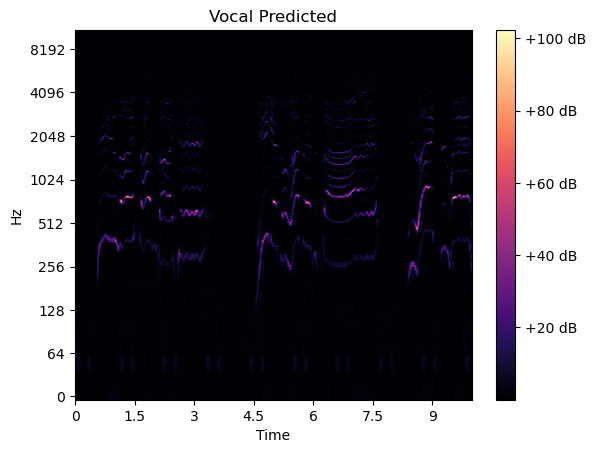

In [97]:
fig, ax = plt.subplots()
img = librosa.display.specshow(np.abs(stft_vp), x_axis='time', y_axis='log', ax=ax)
ax.set(title='Vocal Predicted')
fig.colorbar(img, ax=ax, format="%+2.f dB")
plt.savefig(outpath+'VocalpredictedSpect.png')

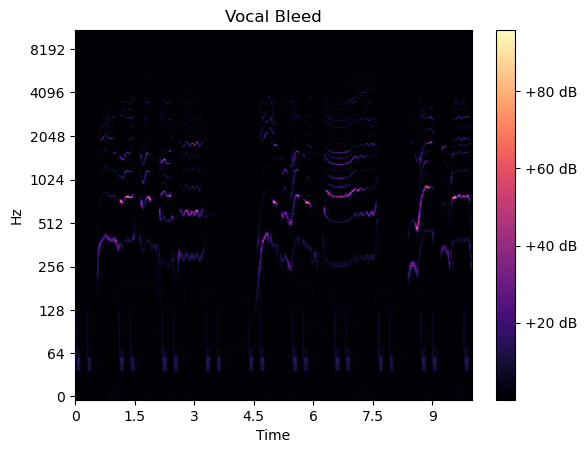

In [98]:
fig, ax = plt.subplots()
img = librosa.display.specshow(np.abs(stft_bv), x_axis='time', y_axis='log', ax=ax)
ax.set(title='Vocal Bleed')
fig.colorbar(img, ax=ax, format="%+2.f dB")
plt.savefig(outpath+'VocalBleedSpect.png')

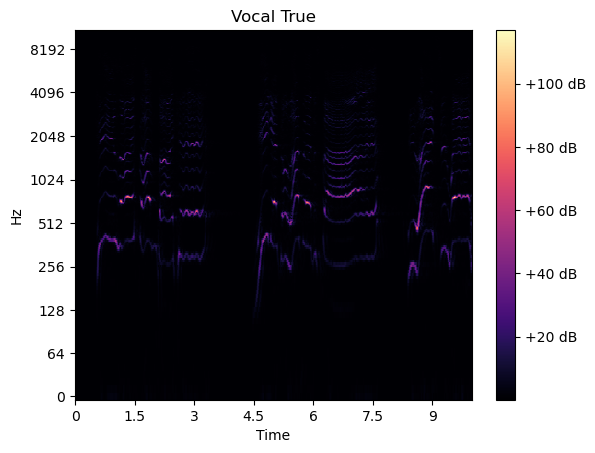

In [51]:
fig, ax = plt.subplots()
img = librosa.display.specshow(np.abs(stft_v), x_axis='time', y_axis='log', ax=ax)
ax.set(title='Vocal True')
fig.colorbar(img, ax=ax, format="%+2.f dB")
plt.savefig(outpath+'VocalTrueSpect.png')